## `.stl`与`.txt`格式点云匹配

- 汪星宇
- 2021年12月


常见的`ICP`是针对点云与点云的，因此对于本问题中的模型与点云并不完全适用，需要对模型进行采样，然后进行`IPC`配准。

`.stl`与`.txt`配准的主要步骤包括：
1. 读取扫描数据点的`.txt`文件，转换成`pcd`格式，`source`
2. 读取由模型导出的`.stl`文件，表面采样得到`pcd`格式点云，`target`
3. 对`source`和`target`进行`Global registration`全局配准，得到粗配准结果`trans_init`
4. 利用`trans_init`和Open3D提供的**point-to-point ICP**和**point-to-plane ICP**分别进行精细ICP配准
5. 计算ICP结果的`source`和`target`距离，评价***配准质量***和***扫描质量***

### 1. 读取`.txt`文件，转换成`pcd`格式

- 直接`np.loadtxt()`, 然后转点云

或者

- 读取txt文件, 数值分割, 字符串转浮点数, 转`ndarray`格式
- 新建`Open3D.PointCloud`对象, 将`ndarray`转成`Open3D.utility.Vector3dVector`, 赋值给`<PointCloud>.points`

> 注意: 原始的的点云扫描数据看起来是没有任何渲染的, 只有坐标位置的点. 因为原始数据没有计算点云法向量, `Open3D.Visualization`不能对其进行渲染.

In [1]:
import open3d as o3d
import numpy as np
import time
import copy
import open3d_tutorial

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


扫描点云数据显示:


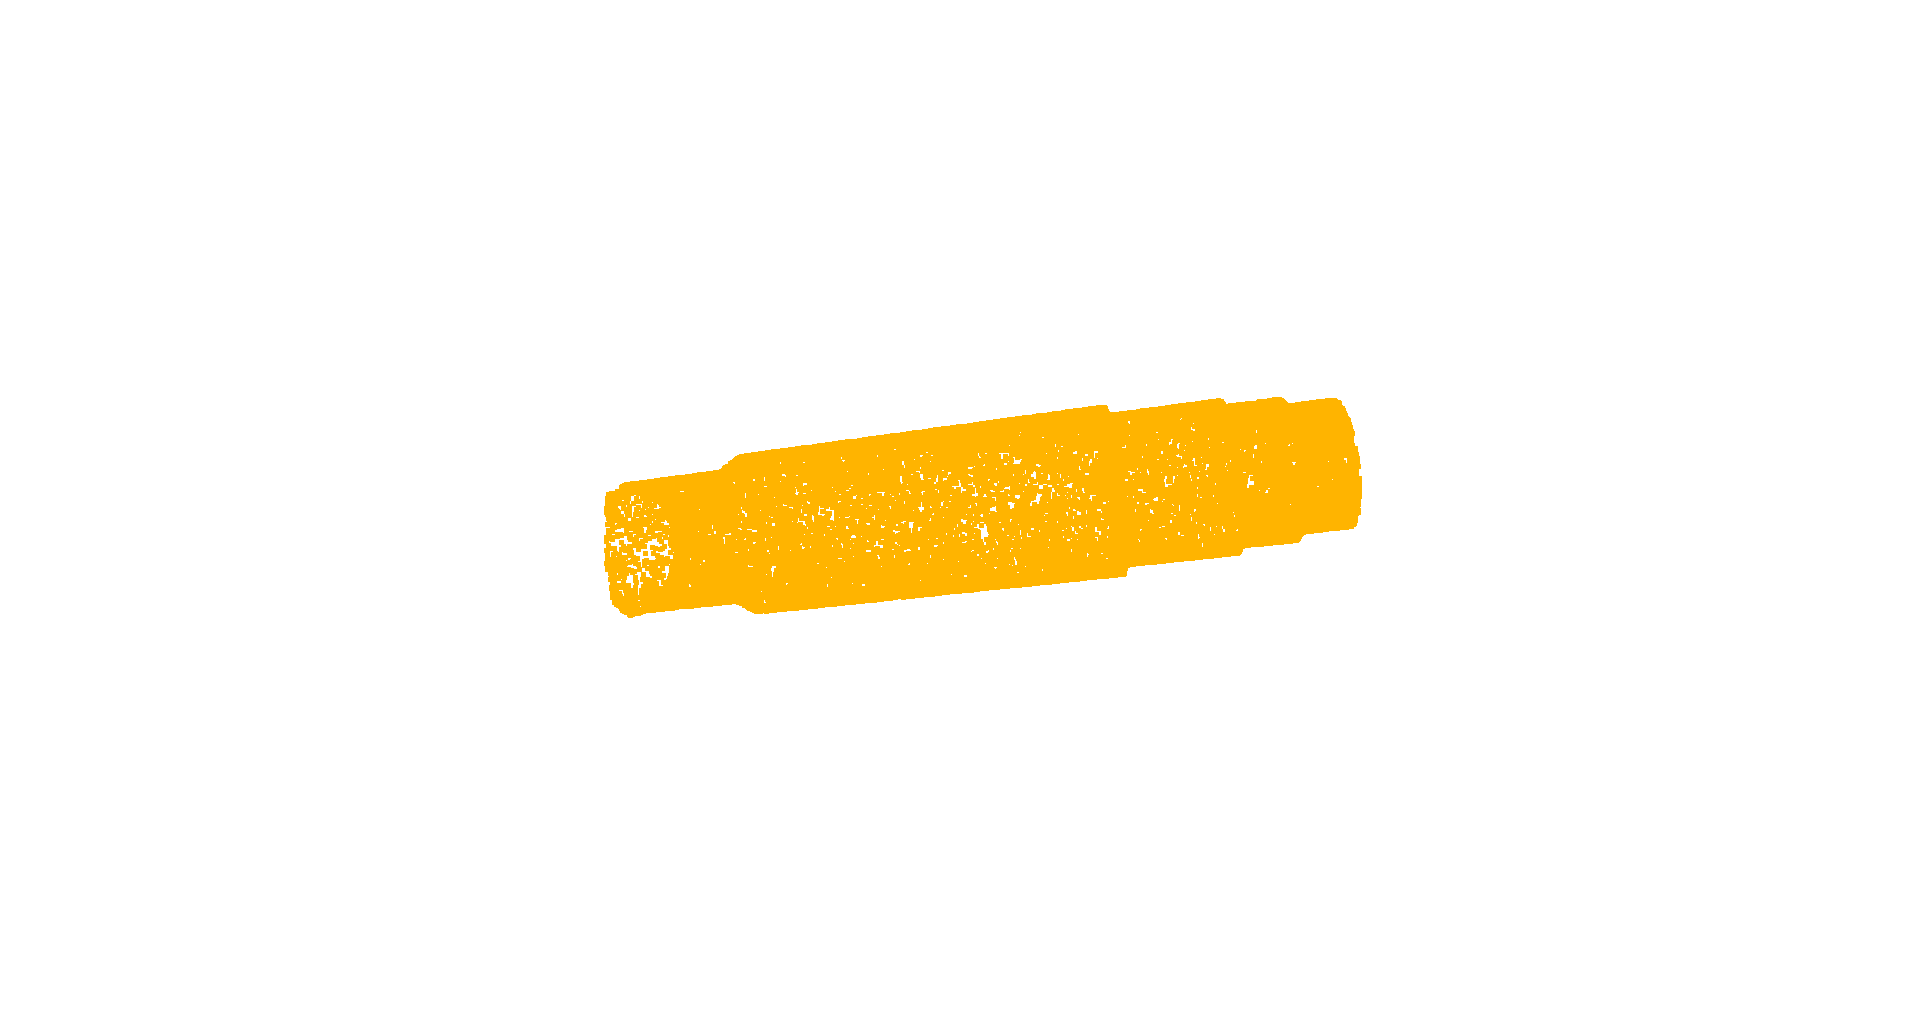

计算法向量后的扫描点云数据显示:


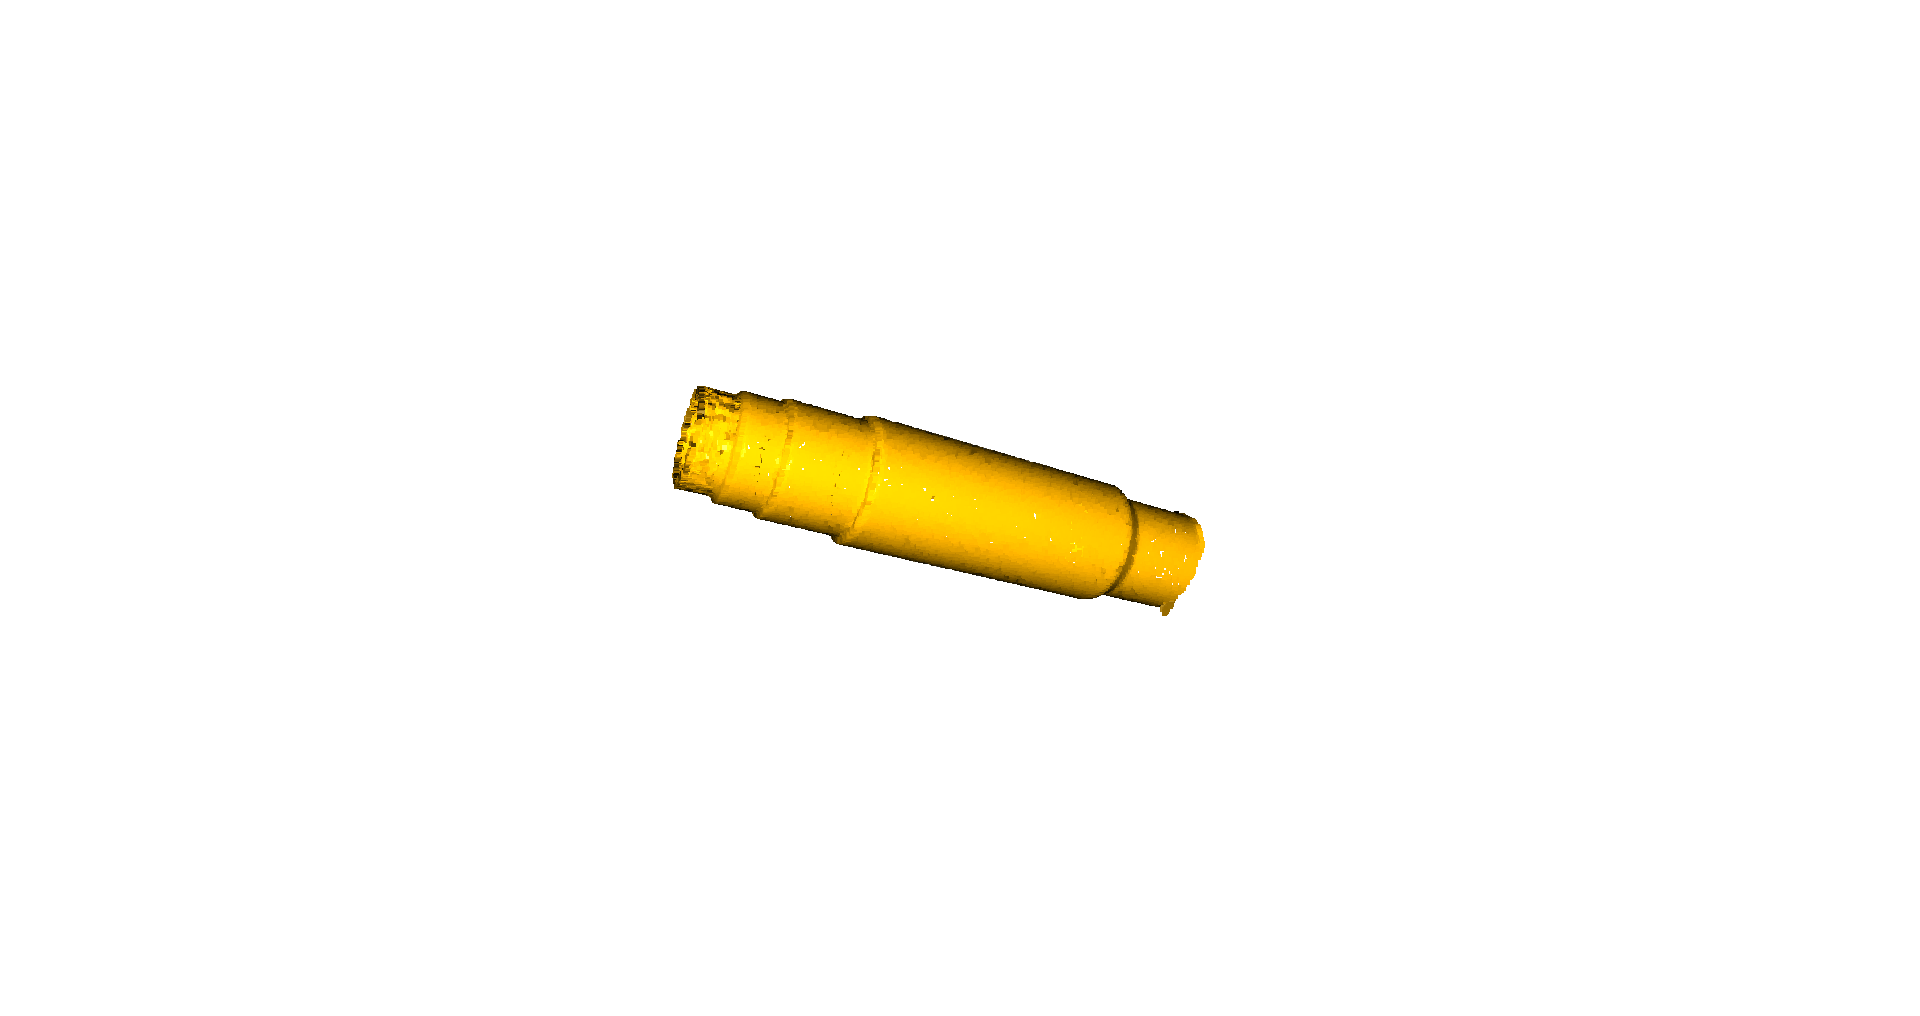

In [5]:
def txt2PointCloud(path):
    """
    读取 txt 到 点云
    :param path: 文件路径
    :return: pcd 点云文件
    """
    with open(path) as temp:
        points = temp.read()
        points = points.strip().split('\n')

        PointXYZ = []
        for i in points:
            PointXYZ.append([float(x) for x in i.split(' ')])

    temp = np.asarray(PointXYZ)
    source = o3d.geometry.PointCloud()
    source.points = o3d.utility.Vector3dVector(temp)
    return source

def draw_registration_result(source, target, transformation):
    """
    点云配准可视化函数
    :param source: 待配准点云 黄色
    :param target: 目标点云 青绿色
    :param transformation: 变换矩阵
    :return: None
    """
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])

# 读取txt扫描数据文件 返回 pcd
sourcePath = "../data/pz.txt"
source = txt2PointCloud(sourcePath)
source.paint_uniform_color([1, 0.706, 0])

temp = copy.deepcopy(source)
temp.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=1, max_nn=30))
print("扫描点云数据显示:")
o3d.visualization.draw_geometries([source])
print("计算法向量后的扫描点云数据显示:")
o3d.visualization.draw_geometries([temp])

### 2. 读取`.stl`文件，表面采样得到`pcd`格式点云
STL 文件由多个三角形面片的定义组成，每个三角形面片的定义包括三角形各个定点的三维坐标及三角形面片的法矢量。

直接读取STL文件, 生成mesh即可. 对mesh进行采样, 这里选择的采样点数和扫描`source`点数保持相同.

stl文件显示如下:


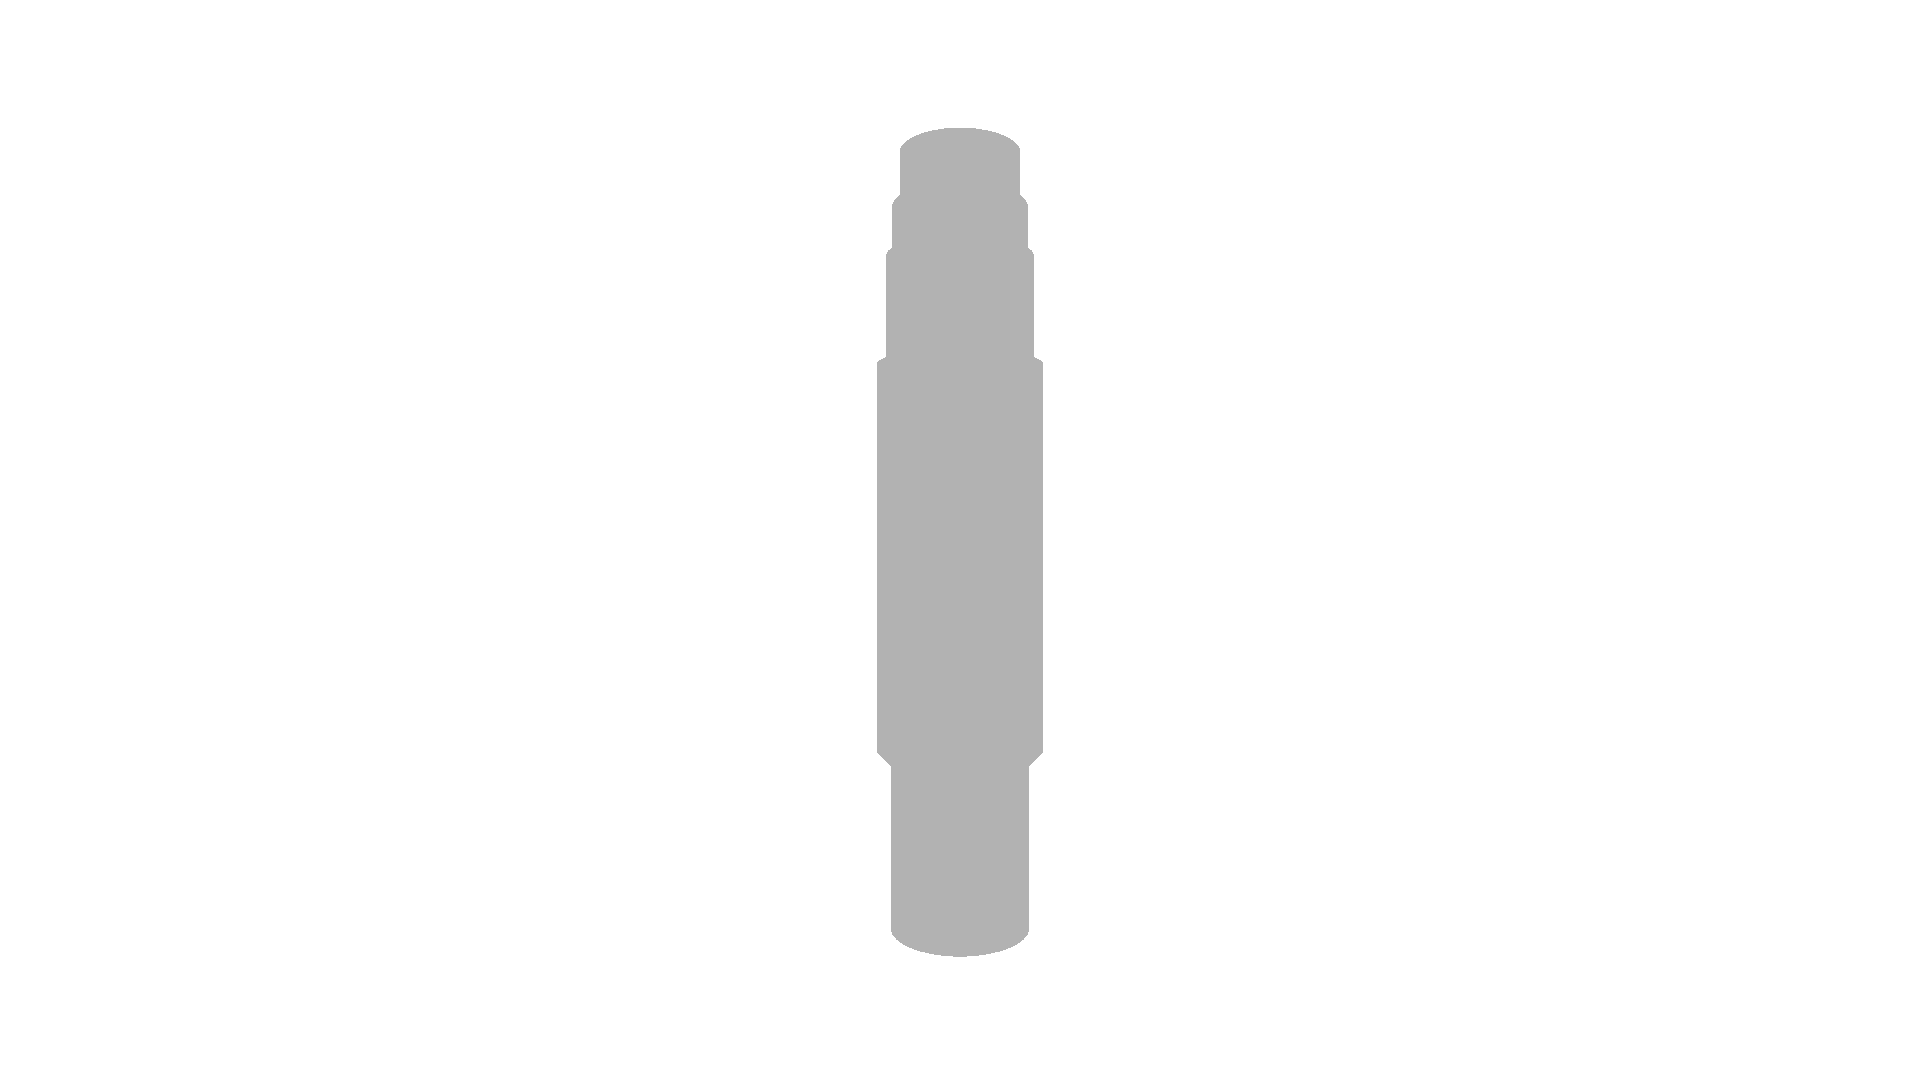

In [3]:
# 读取 mesh
targetPath = "../data/pz.STL"
mesh = o3d.io.read_triangle_mesh(targetPath)

# mesh 采样生成 pcd
numbers_of_points = len(source.points)
target = mesh.sample_points_poisson_disk(number_of_points=numbers_of_points, init_factor=5)
target.paint_uniform_color([0, 0.651, 0.929])
print('stl文件显示如下:')
o3d.visualization.draw_geometries([mesh])

扫描点云数据(黄)和stl采样点云数据(蓝):


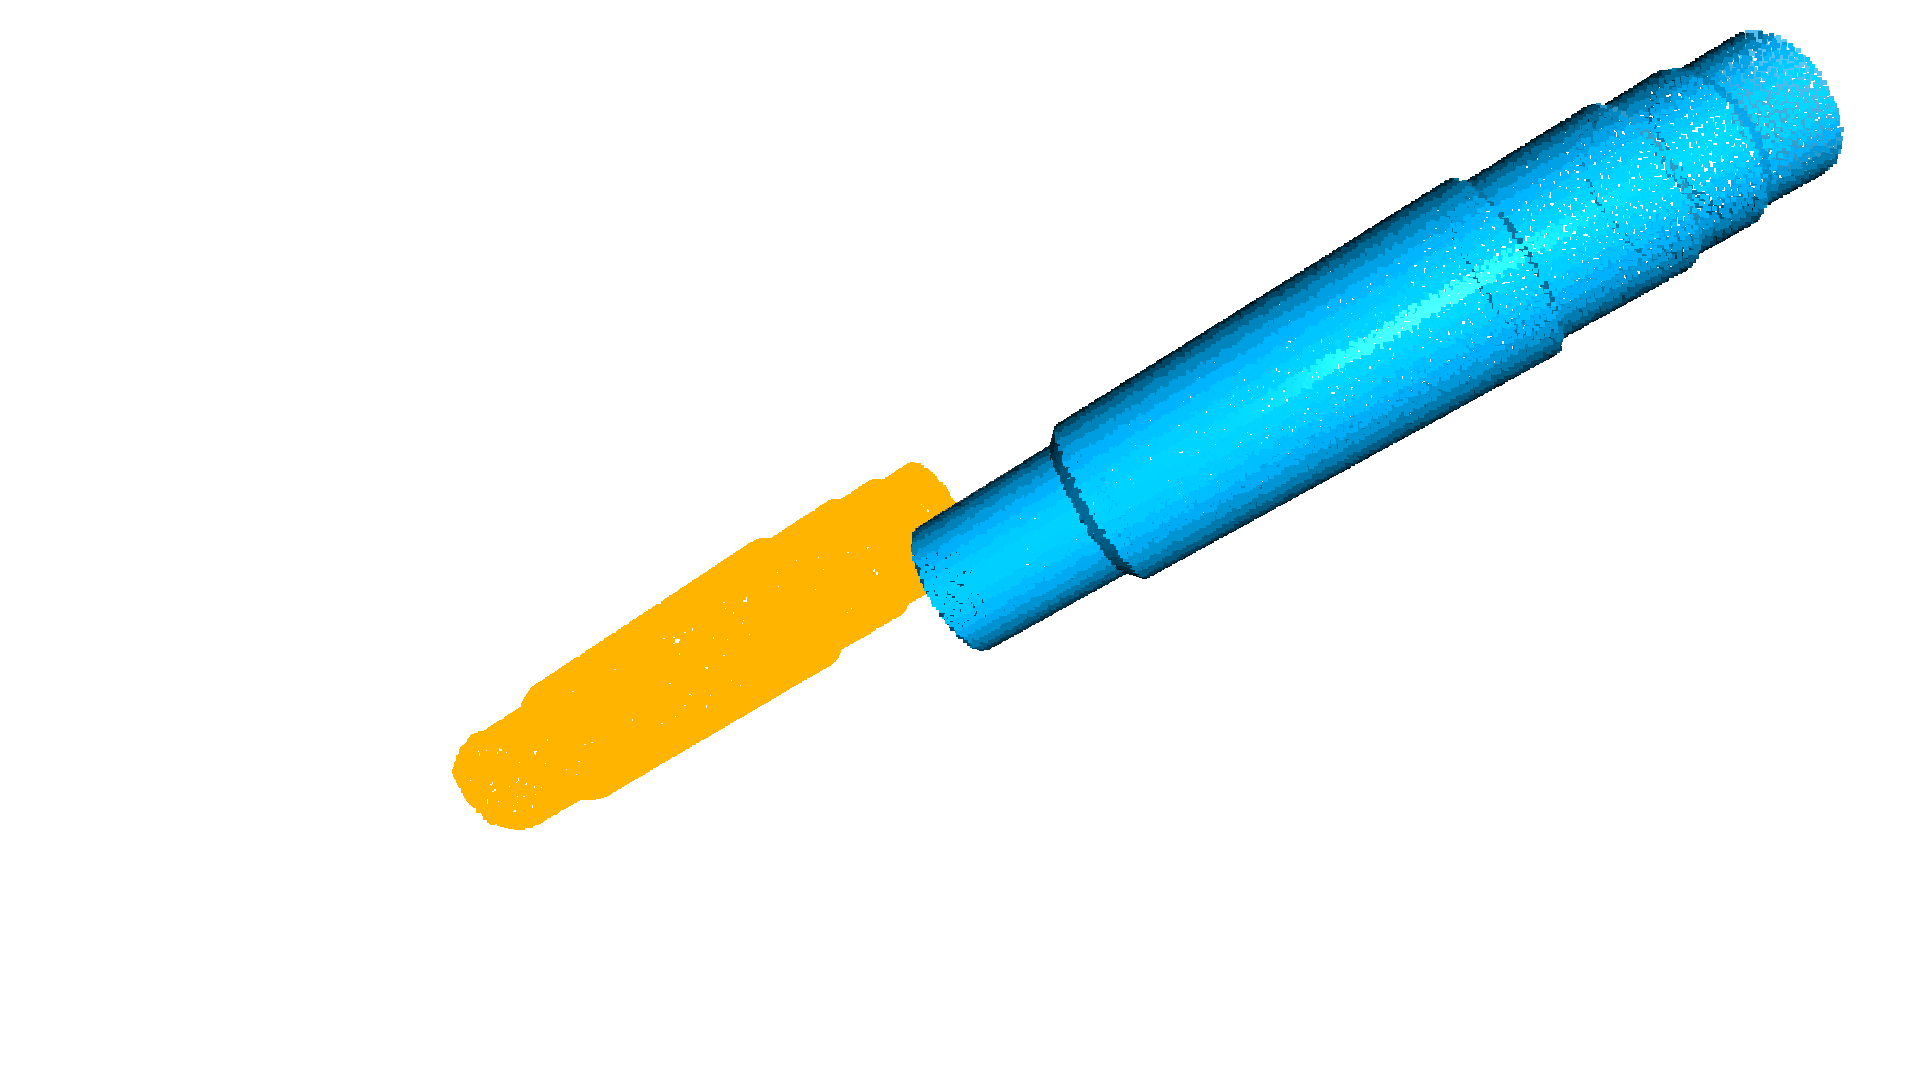

In [4]:
# 原始数据显示
print("扫描点云数据(黄)和stl采样点云数据(蓝):")
o3d.visualization.draw_geometries([source, target])

### 3.对`source`和`target`进行`Global registration`全局配准
全局配准采用了`RANSAC`随机采样一致性方法, `Open3D.pipelines.registration.registration_ransac_based_on_feature_matching()`内部有一些用于剪枝的参数, 以及对迭代配准结果的限制参数, 需要根据经验和相关文献提供的规则进行判断选取.

Open3D也提供了**快速全局配准**方法, 能够实现快速的高精度全局配准, 其结果可以与ICP媲美, [Global registration](http://www.open3d.org/docs/release/tutorial/pipelines/global_registration.html)

>注意：
- 全局配准计算量较大, 提前降采样是一种常见的处理手段, 原理上是可以跳过的.
- threshold的选取比较重要，和物体尺寸高度相关，一般物体尺寸越大，阈值越小，反之则越大。和点云的密度也有一定的关系，但尚不明确。
- 由于threshold选取不当，可能造成粗、精配准不收敛，且增加迭代次数不能使其收敛。

In [5]:
def preprocess_point_cloud(pcd, voxel_size):
    """
    点云预处理 降采样, 计算法向量, 计算特征直方图
    :param pcd: 点云数据
    :param voxel_size: 体素采样大小
    :return: 降采样后点云, FPFH点快速特征直方图
    """
    print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd.voxel_down_sample(voxel_size)

    radius_normal = voxel_size * 2
    print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 5
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh


def prepare_dataset(source, target, voxel_size):
    """
    点云文件预处理函数, 降采样, 计算法向量, 计算特征直方图
    :param voxel_size: 体素大小
    :return: source, target, source_down, target_down, source_fpfh, target_fpfh
    """
    source_down, source_fpfh = preprocess_point_cloud(source, voxel_size)
    target_down, target_fpfh = preprocess_point_cloud(target, voxel_size)
    return source_down, target_down, source_fpfh, target_fpfh


def execute_global_registration(source_down, target_down, source_fpfh,
                                target_fpfh, voxel_size):
    """
    全局匹配函数
    :param source_down:
    :param target_down:
    :param source_fpfh:
    :param target_fpfh:
    :param voxel_size:
    :return:
    """
    distance_threshold = voxel_size * 1.5
    print(":: RANSAC registration on downsampled point clouds.")
    print("   Since the downsampling voxel size is %.3f," % voxel_size)
    print("   we use a liberal distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh, True,
        distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        3, [
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(
                0.9),
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(
                distance_threshold)
        ], o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999))
    return result

:: Downsample with a voxel size 1.000.
:: Estimate normal with search radius 2.000.
:: Compute FPFH feature with search radius 5.000.
:: Downsample with a voxel size 1.000.
:: Estimate normal with search radius 2.000.
:: Compute FPFH feature with search radius 5.000.


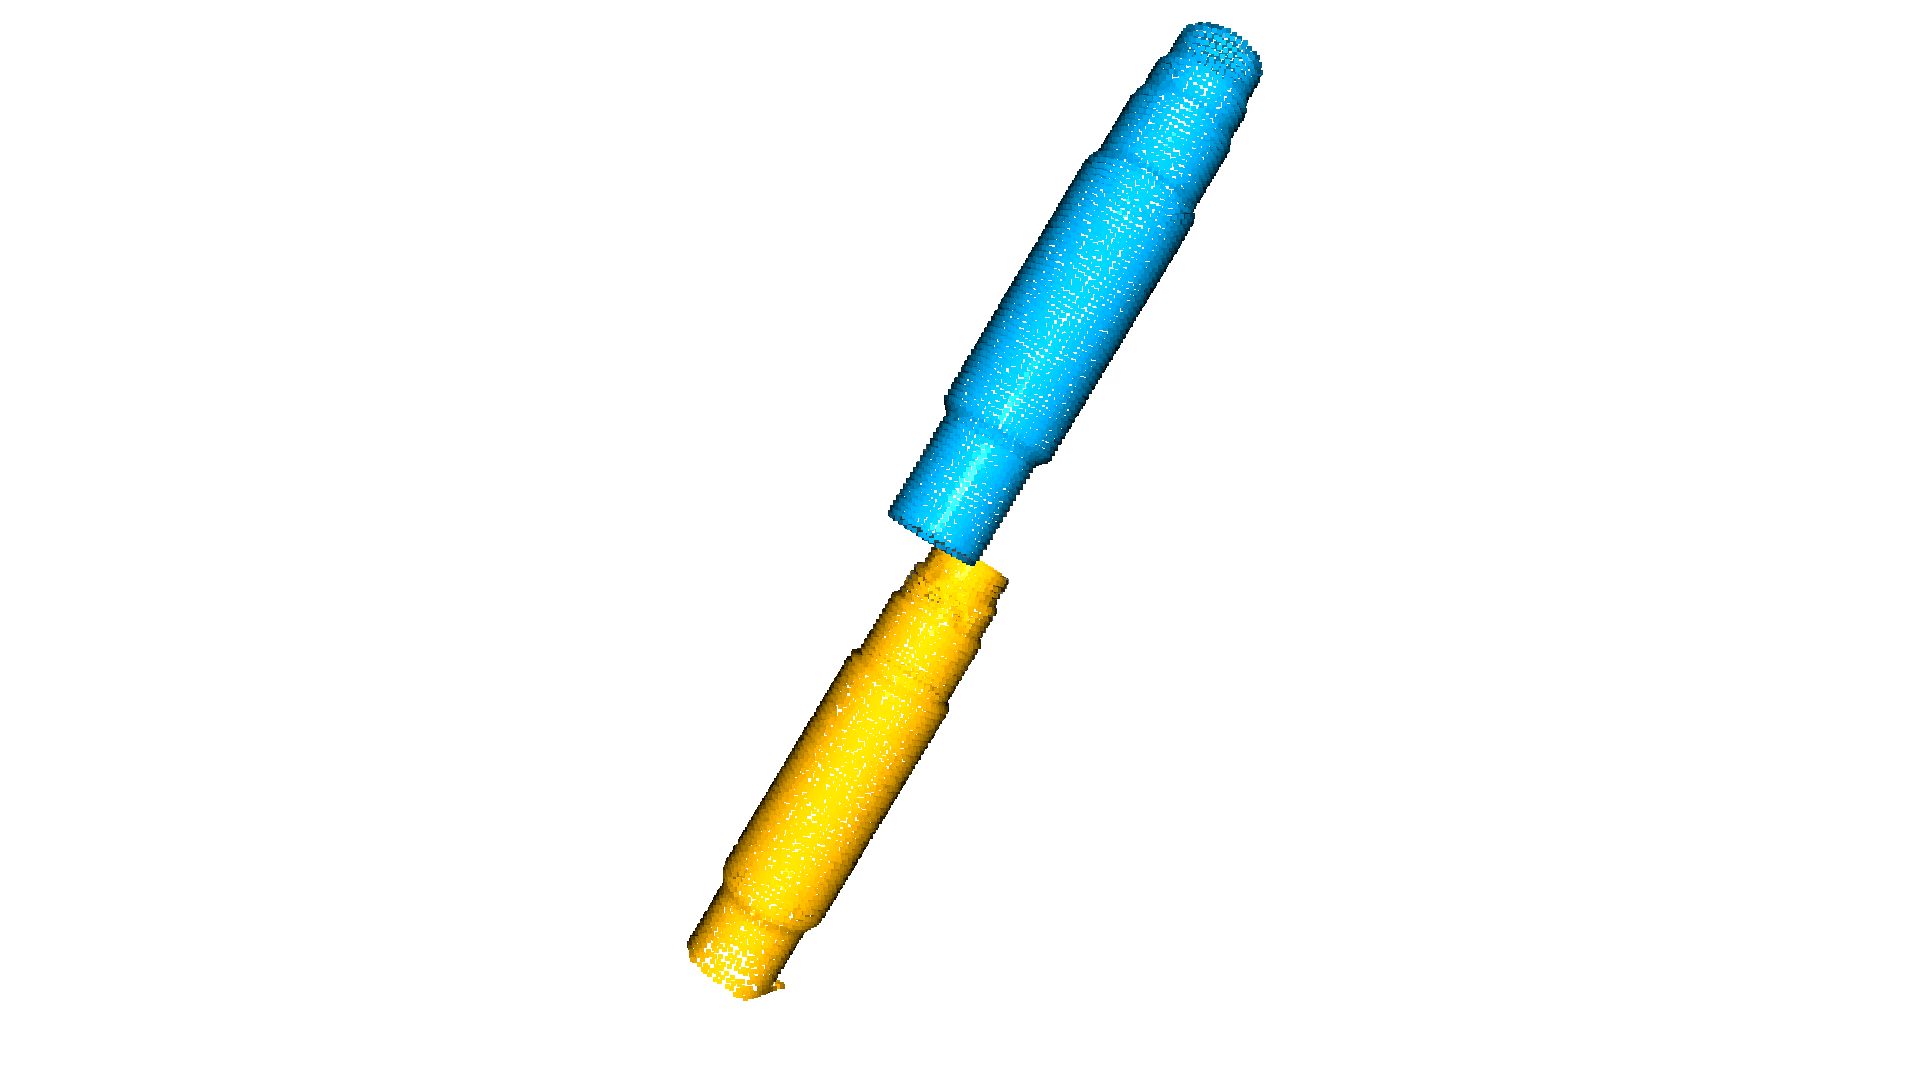

:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 1.000,
   we use a liberal distance threshold 1.500.
全局配准结果: RegistrationResult with fitness=4.054054e-02, inlier_rmse=9.482664e-01, and correspondence_set size of 15
Access transformation to get result.
全局配准矩阵: [[ 9.93422444e-01  2.18972823e-03  1.14486040e-01  9.23527633e+00]
 [-2.53901187e-03  9.99992557e-01  2.90515287e-03  8.55649734e+01]
 [-1.14478826e-01 -3.17672547e-03  9.93420609e-01  8.49963221e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]




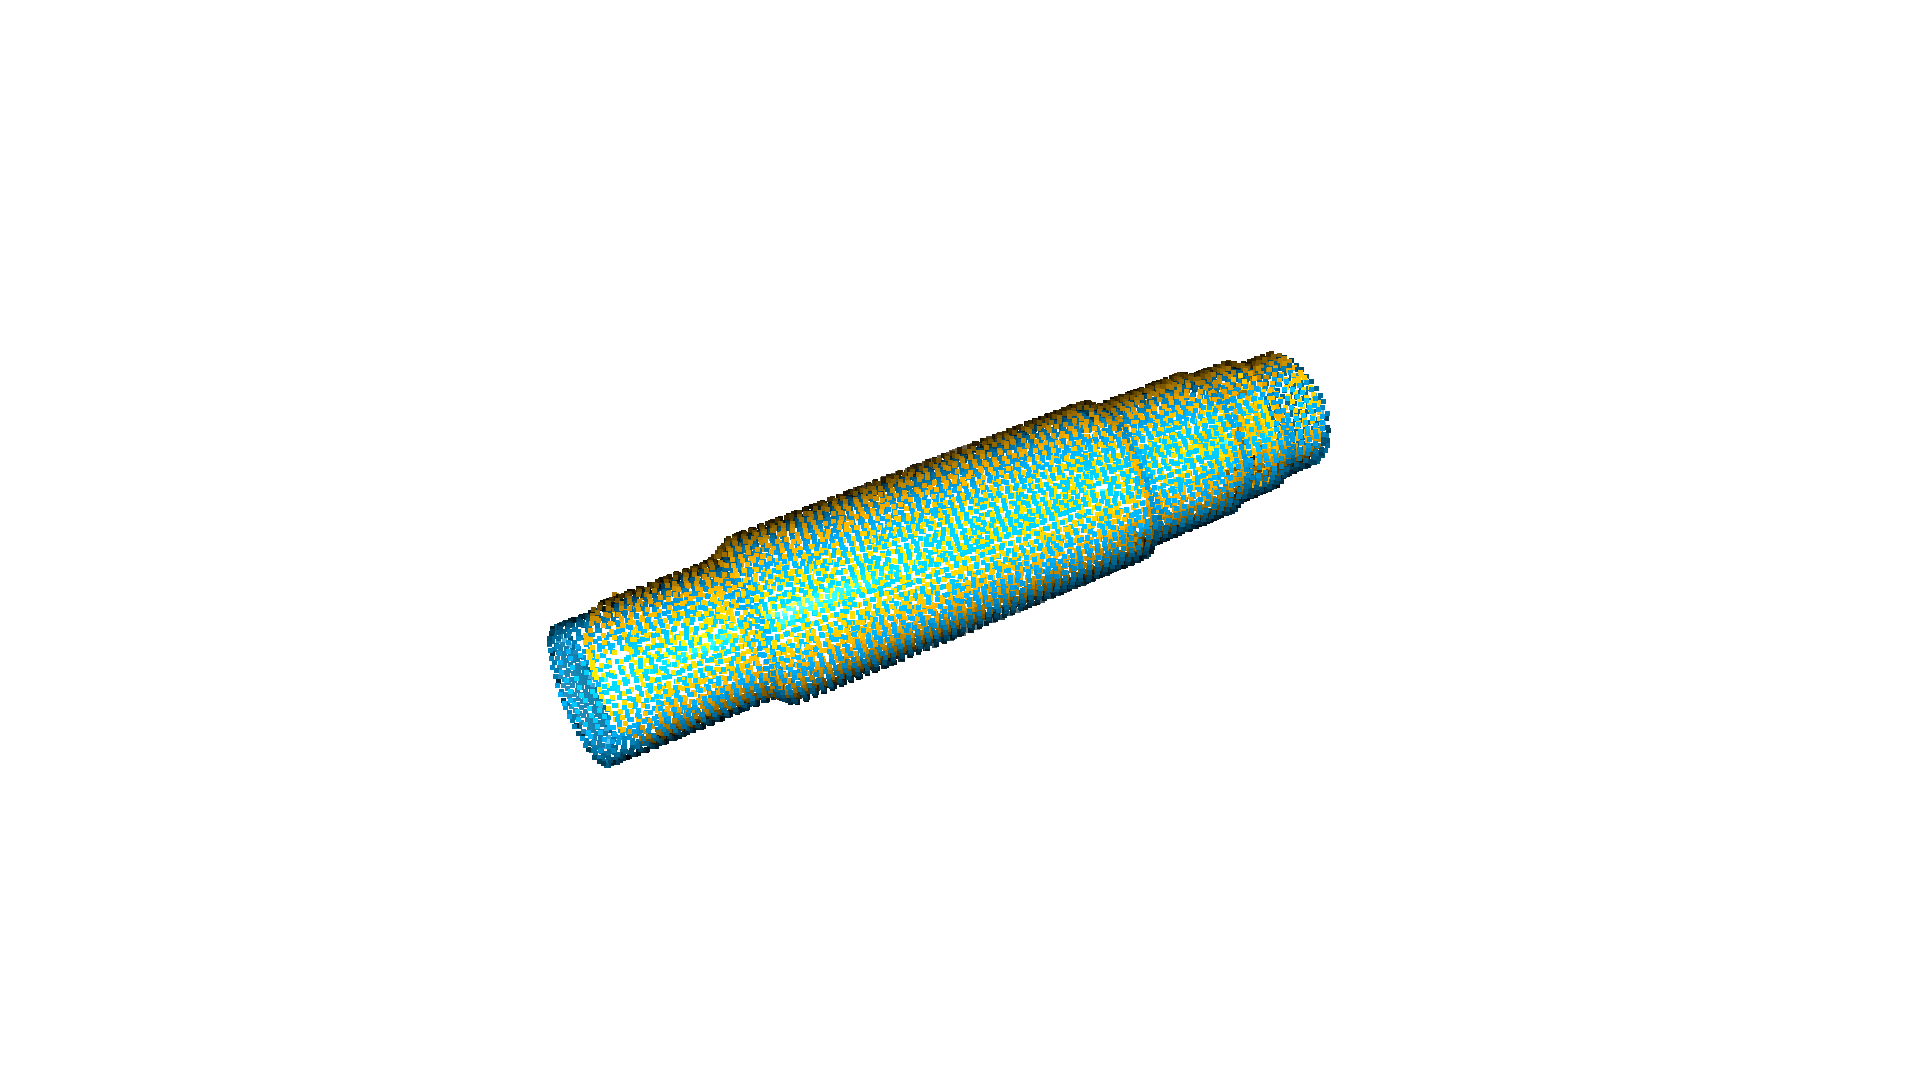

In [6]:
# 降采样 粗配准
voxel_size = 1  #
source_down, target_down, source_fpfh, target_fpfh = prepare_dataset(source, target, voxel_size)
draw_registration_result(source_down, target_down, np.identity(4))

# 粗配准, 及结果显示
result_ransac = execute_global_registration(source_down, target_down, source_fpfh, target_fpfh, voxel_size)
trans_init = np.array(result_ransac.transformation)
print("全局配准结果:", result_ransac)
print("全局配准矩阵:", trans_init)
print('\n')
draw_registration_result(source_down, target_down, trans_init)


### 4. 利用全局配准结果，对`source`和`target`进行**point-to-point ICP**和**point-to-plane ICP**

ICP配准是局部的, 官方提供了详尽的解释与[参考](http://www.open3d.org/docs/release/tutorial/t_pipelines/t_icp_registration.html)

#### 4.1. 点对点ICP


Apply point-to-point ICP
RegistrationResult with fitness=9.361826e-01, inlier_rmse=2.274976e-01, and correspondence_set size of 24117
Access transformation to get result.
Transformation is:
[[ 9.93751634e-01 -2.29061641e-04  1.11613790e-01  9.22929245e+00]
 [ 3.81964379e-04  9.99999018e-01 -1.34854582e-03  8.57799033e+01]
 [-1.11613372e-01  1.38275210e-03  9.93750745e-01  9.31211759e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
运算时间: 0.19217395782470703 s 



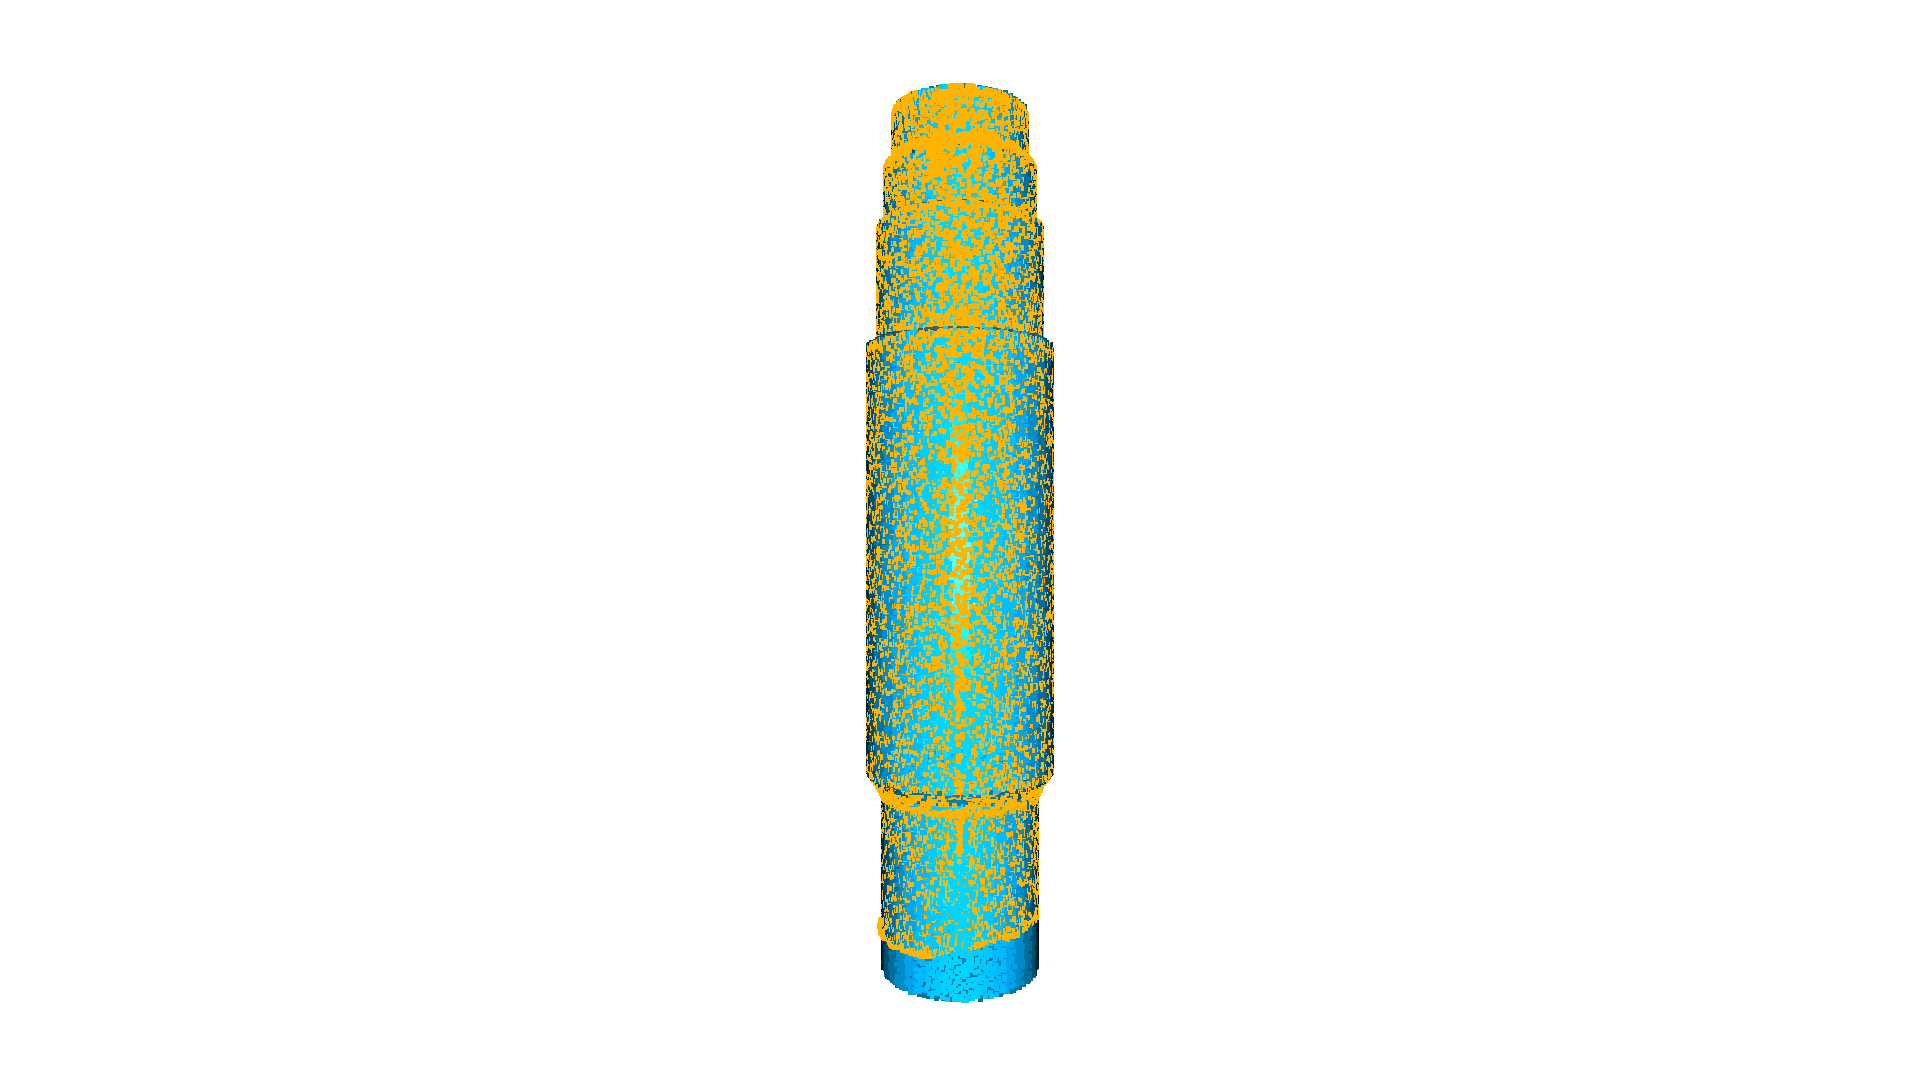

In [7]:
def ICPP2P(source, target, threshold, trans_init, maxIteration=30):
    """
    点对点ICP函数
    :param source:
    :param target:
    :param threshold:
    :param trans_init:
    :param maxIteration:
    :return: 配准结果对象
    """
    # 开始时间
    startTime = time.time()

    # ICP 配准 默认30次迭代
    print("Apply point-to-point ICP")
    reg_p2p = o3d.pipelines.registration.registration_icp(
        source, target, threshold, trans_init,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=maxIteration))
    print(reg_p2p)
    print("Transformation is:")
    print(reg_p2p.transformation)
    endTime = time.time()
    print('运算时间: {} s'.format(endTime - startTime), '\n')
    return reg_p2p

# 点对点ICP
threshold = 0.5    # 阈值匹配
reg_p2p = ICPP2P(source, target, threshold, trans_init, 1000)
draw_registration_result(source, target, reg_p2p.transformation)

#### 4.2. 点对面ICP
点对面ICP在运算中运用了点云法向量, 理论精度更高.

Apply point-to-plane ICP
RegistrationResult with fitness=9.365708e-01, inlier_rmse=2.275362e-01, and correspondence_set size of 24127
Access transformation to get result.
Transformation is:
[[ 9.95045591e-01 -7.80382683e-05  9.94196397e-02  9.23815883e+00]
 [ 2.03364116e-04  9.99999198e-01 -1.25044068e-03  8.58161212e+01]
 [-9.94194623e-02  1.26446387e-03  9.95044809e-01  9.30724213e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
运算时间: 0.054048776626586914 s 



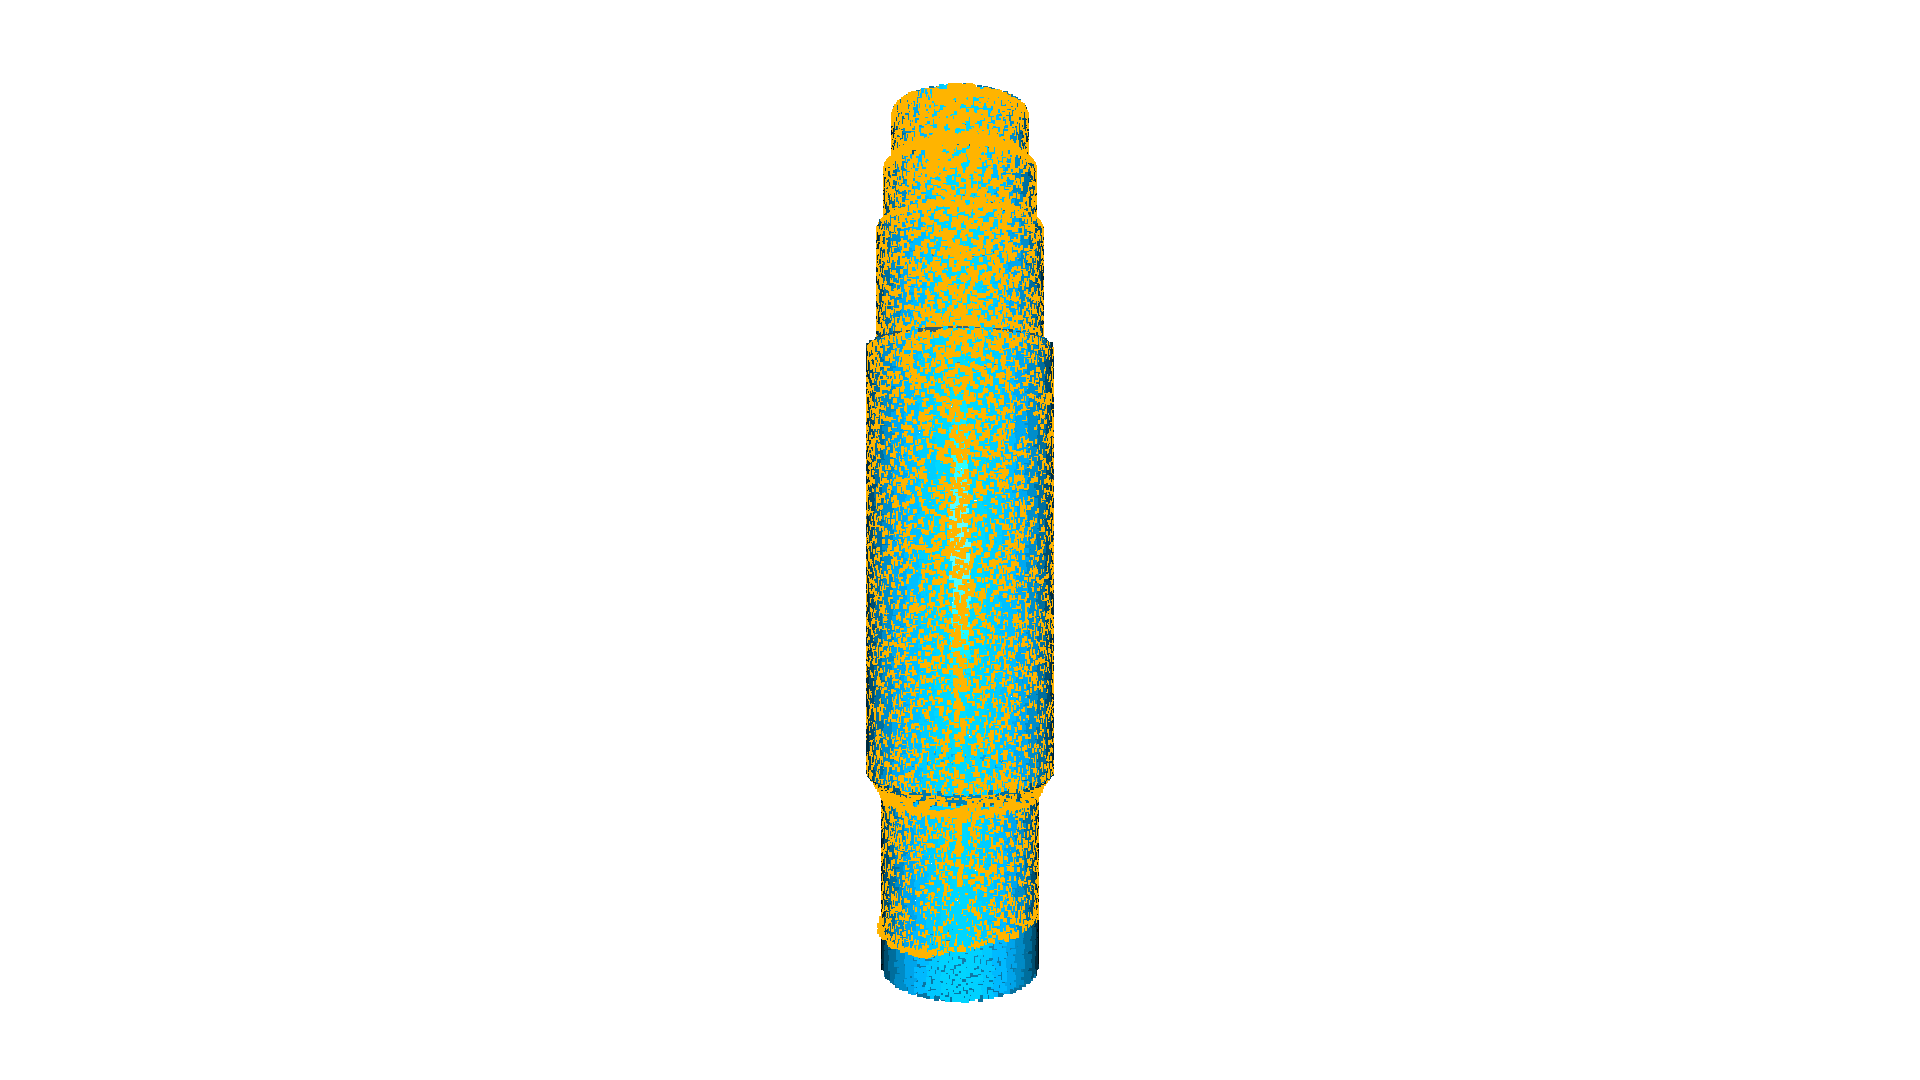

In [8]:
def ICPP2l(source, target, threshold, trans_init, maxIteration=30):
    """
    点对面ICP函数
    :param source:
    :param target:
    :param threshold:
    :param trans_init:
    :param maxIteration:
    :return: 点对面ICP结果对象
    """
    # 开始时间
    startTime = time.time()

    print("Apply point-to-plane ICP")
    reg_p2l = o3d.pipelines.registration.registration_icp(
        source, target, threshold, trans_init,
        o3d.pipelines.registration.TransformationEstimationPointToPlane(),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=maxIteration))
    print(reg_p2l)
    print("Transformation is:")
    print(reg_p2l.transformation)
    endTime = time.time()
    print('运算时间: {} s'.format(endTime - startTime), '\n')
    return reg_p2l

# 点对面ICP
reg_p2l = ICPP2l(source, target, threshold, trans_init, 1000)
draw_registration_result(source, target, reg_p2l.transformation)

### 5. 计算ICP结果的`source`和`target`距离

后续尝试了新的点云距离显示方法,

配准结果评价，绿点代表ICP结果很好，红点代表结果超出阈值


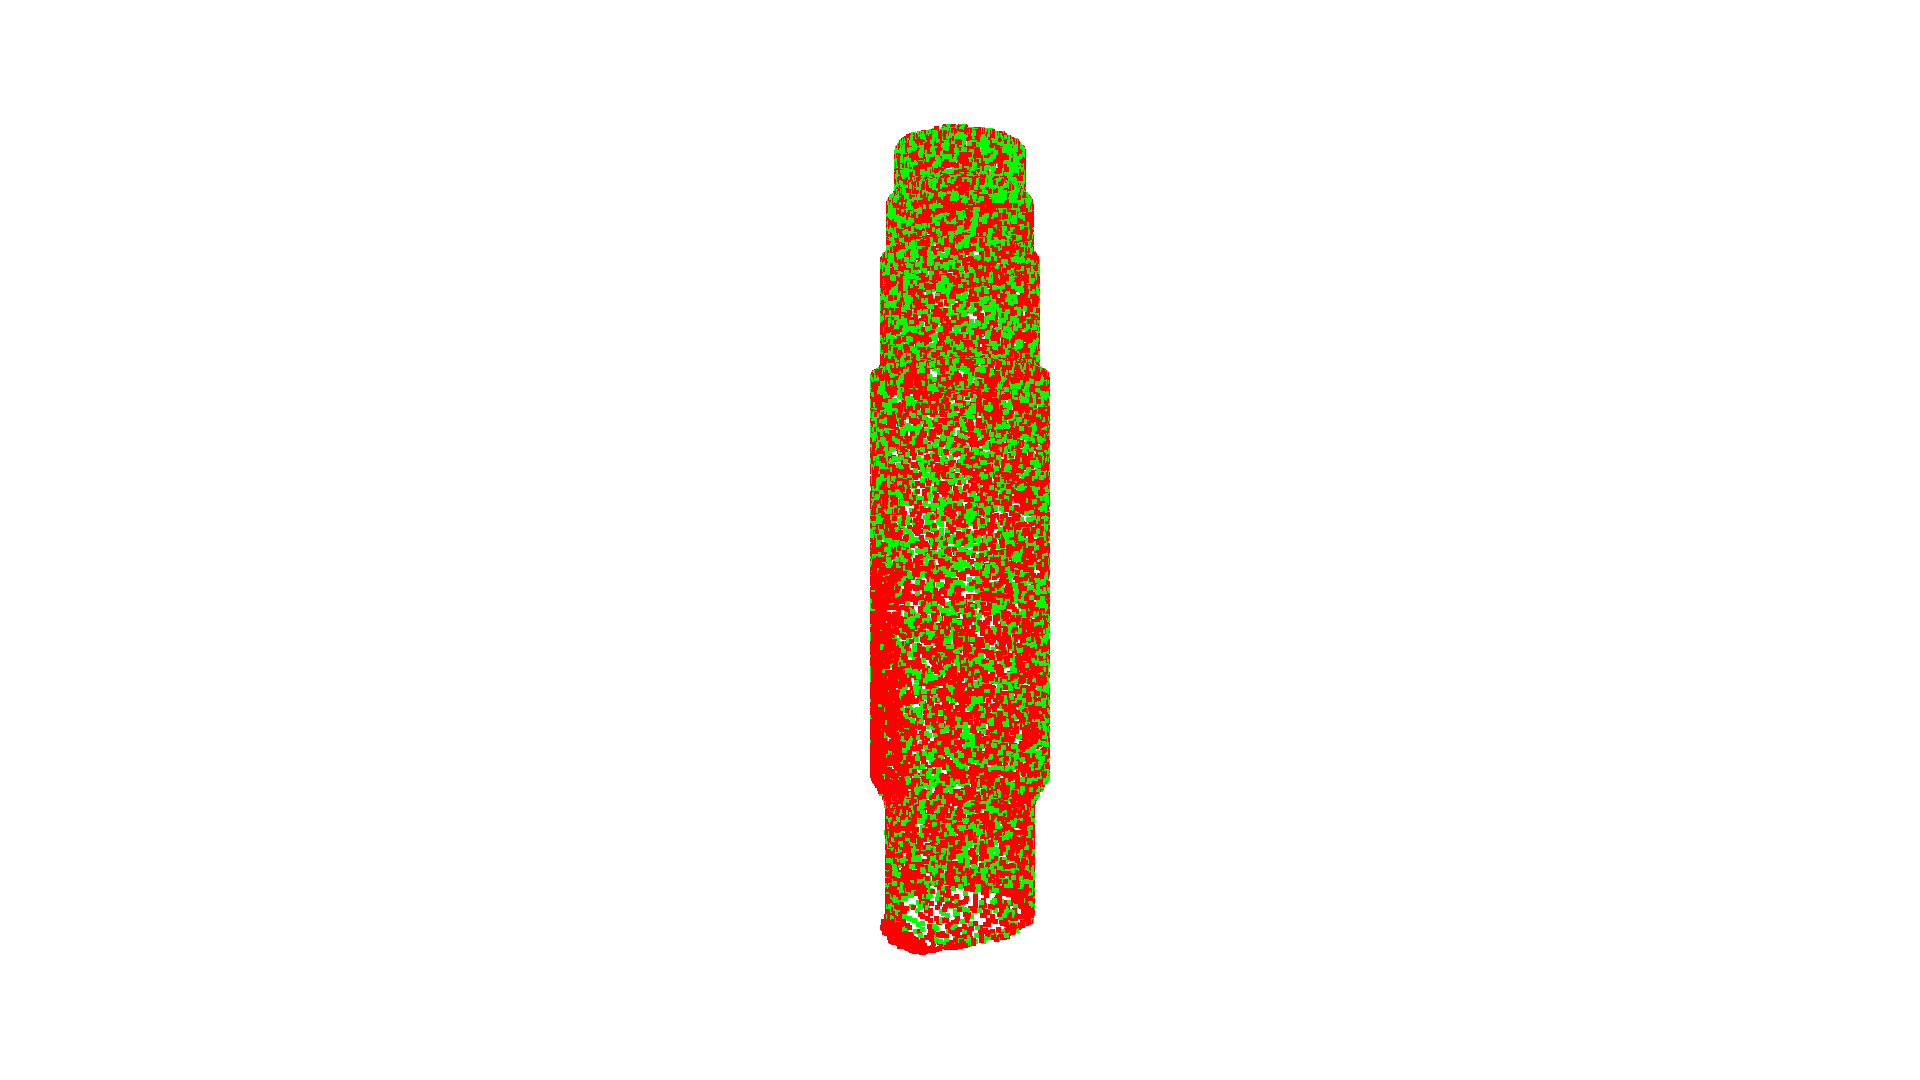

In [9]:
# 距离计算
temp = copy.deepcopy(source)
temp = temp.transform(reg_p2p.transformation)
temp.paint_uniform_color([1,0,0])
dists = target.compute_point_cloud_distance(temp)

dists = np.asarray(dists)
ind = np.where(dists < 0.2)[0]
wellFitPoints = source.select_by_index(ind)     # 配准较好的点
wellFitPoints.paint_uniform_color([0,1,0])
badFitPoints = source.select_by_index(ind, invert=True) # 配准超过阈值的点
badFitPoints.paint_uniform_color([1,0,0])
print("配准结果评价，绿点代表ICP结果很好，红点代表结果超出阈值")
o3d.visualization.draw_geometries([badFitPoints, wellFitPoints])